In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [3]:
# GPU利用可なら自動的に切り替え
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("使用デバイス:", device)

使用デバイス: cuda


In [4]:
import pandas as pd
df = pd.read_csv(r"/root/workspace/gaze.csv")

/tmp/ipykernel_3766/749066812.py:2: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"/root/workspace/gaze.csv")


In [5]:
df.columns.tolist()

['Unnamed: 0',
 'time',
 'time2',
 'left_x',
 'left_y',
 'right_x',
 'right_y',
 'left_pupil',
 'right_pupil',
 'score',
 'q_category',
 'question',
 'Q',
 'CD_RISC_TOTAL',
 'CD_RISC_READING',
 'CD_RISC_MEMORY',
 'CD_RISC_RECOGNITION',
 'CD_RISC_ATTENTION',
 'SRS_18',
 'ERQ_EVALUATION_AVE',
 'ERQ_SUPPRESSION_AVE',
 'Time',
 'device_time_stamp',
 'system_time_stamp',
 'pc_time_stamp']

In [6]:
import numpy as np
# Xとyに分割
X = df[['left_x', 'left_y', 'right_x', 'right_y', 'left_pupil', 'right_pupil']].values

# pandas DataFrame化
X_df = pd.DataFrame(X)
# 線形補間（欠損が連続しても対応）
X_df = X_df.interpolate(method='linear', limit_direction='both')
# 補間後のNaNを0で埋める（端の安全策）
X_df = X_df.fillna(0)
# numpy配列に戻す
X = X_df.to_numpy().astype(np.float32)

df['score'] = df['score'].replace({2:1})
y = df['score'].values

In [7]:
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (974230, 6)
y shape: (974230,)


In [8]:
from scipy.stats import mode
# ======================================
# 🪄 3. 時系列データをTransformer入力形式に変換
# ======================================
seq_len = 100
feature_dim = X.shape[1]
num_classes = 2

num_sequences = X.shape[0] // seq_len
X = X[:num_sequences * seq_len]
y = y[:num_sequences * seq_len]

X = X.reshape(num_sequences, seq_len, feature_dim)
y = y.reshape(num_sequences, seq_len)

# 各系列の代表ラベル：多数決 or 最終時点ラベル
y = mode(y, axis=1, keepdims=False)[0]
# y = y[:, -1]  # ←最終ステップのラベルにする場合はこちら

print("系列数:", num_sequences)
print("X:", X.shape, " y:", y.shape)

系列数: 9742
X: (9742, 100, 6)  y: (9742,)


In [11]:
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.model_selection import StratifiedShuffleSplit
# ======================================
# 🔢 TensorDataset 作成
# ======================================
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)
dataset = TensorDataset(X_tensor, y_tensor)

# ======================================
# ⚖️ 層化分割 (train/val/test)
# ======================================
test_ratio = 0.15
val_ratio = 0.15

# --- まず train+val と test に分割 ---
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=test_ratio, random_state=42)
trainval_idx, test_idx = next(sss1.split(X, y))

# --- 次に train+val を train と val に分割 ---
y_trainval = y[trainval_idx]
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=val_ratio / (1 - test_ratio), random_state=42)
train_idx, val_idx = next(sss2.split(X[trainval_idx], y_trainval))

# --- インデックスをTensorDatasetに適用 ---
train_ds = Subset(dataset, trainval_idx[train_idx])
val_ds   = Subset(dataset, trainval_idx[val_idx])
test_ds  = Subset(dataset, test_idx)

# ======================================
# 📦 DataLoader作成
# ======================================
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False)

print(f"train: {len(train_ds)}  val: {len(val_ds)}  test: {len(test_ds)}")

train: 6818  val: 1462  test: 1462


In [ ]:
# ======== クラス分布の確認 ========
import numpy as np

def check_class_ratio(y, idx):
    vals, counts = np.unique(y[idx], return_counts=True)
    ratio = counts / counts.sum()
    return dict(zip(vals, ratio))

print("Train:", check_class_ratio(y, trainval_idx[train_idx]))
print("Val:  ", check_class_ratio(y, trainval_idx[val_idx]))
print("Test: ", check_class_ratio(y, test_idx))

Train: {0: 0.311088295687885, 1: 0.688911704312115}
Val:   {0: 0.3112175102599179, 1: 0.688782489740082}
Test:  {0: 0.3112175102599179, 1: 0.688782489740082}


In [21]:
# ======================================
# 🧠 5. Transformerモデル構築（関数・クラス未使用）
# ======================================
feature_dim = 6
hidden_dim = 64
num_heads = 2
num_layers = 2
num_classes = 2
dropout = 0.1

embedding = nn.Linear(feature_dim, hidden_dim)

encoder_layer = nn.TransformerEncoderLayer(
    d_model=hidden_dim,
    nhead=num_heads,
    dim_feedforward=hidden_dim * 4,
    dropout=dropout,
    activation="relu",
    batch_first=True
)
transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

pool = nn.AdaptiveAvgPool1d(1)
fc = nn.Linear(hidden_dim, num_classes)
softmax = nn.Softmax(dim=1)

embedding.to(device)
transformer.to(device)
pool.to(device)
fc.to(device)
softmax.to(device)

Softmax(dim=1)

In [22]:
# ======================================
# ⚙️ 6. 損失関数・最適化手法
# ======================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    list(embedding.parameters()) +
    list(transformer.parameters()) +
    list(fc.parameters()),
    lr=1e-4
)

Epoch [1/500] TrainLoss: 0.5637  ValLoss: 0.5901  TrainAcc: 0.7404  ValAcc: 0.7079
Epoch [2/500] TrainLoss: 0.5644  ValLoss: 0.5901  TrainAcc: 0.7405  ValAcc: 0.7079
Epoch [3/500] TrainLoss: 0.5644  ValLoss: 0.5901  TrainAcc: 0.7410  ValAcc: 0.7079
Epoch [4/500] TrainLoss: 0.5640  ValLoss: 0.5901  TrainAcc: 0.7405  ValAcc: 0.7079
Epoch [5/500] TrainLoss: 0.5640  ValLoss: 0.5901  TrainAcc: 0.7420  ValAcc: 0.7079
Epoch [6/500] TrainLoss: 0.5641  ValLoss: 0.5901  TrainAcc: 0.7408  ValAcc: 0.7079
Epoch [7/500] TrainLoss: 0.5628  ValLoss: 0.5901  TrainAcc: 0.7414  ValAcc: 0.7079
Epoch [8/500] TrainLoss: 0.5641  ValLoss: 0.5901  TrainAcc: 0.7408  ValAcc: 0.7079
Epoch [9/500] TrainLoss: 0.5634  ValLoss: 0.5901  TrainAcc: 0.7413  ValAcc: 0.7079
Epoch [10/500] TrainLoss: 0.5633  ValLoss: 0.5901  TrainAcc: 0.7414  ValAcc: 0.7079
Epoch [11/500] TrainLoss: 0.5630  ValLoss: 0.5901  TrainAcc: 0.7435  ValAcc: 0.7079
Epoch [12/500] TrainLoss: 0.5633  ValLoss: 0.5901  TrainAcc: 0.7419  ValAcc: 0.7079
E

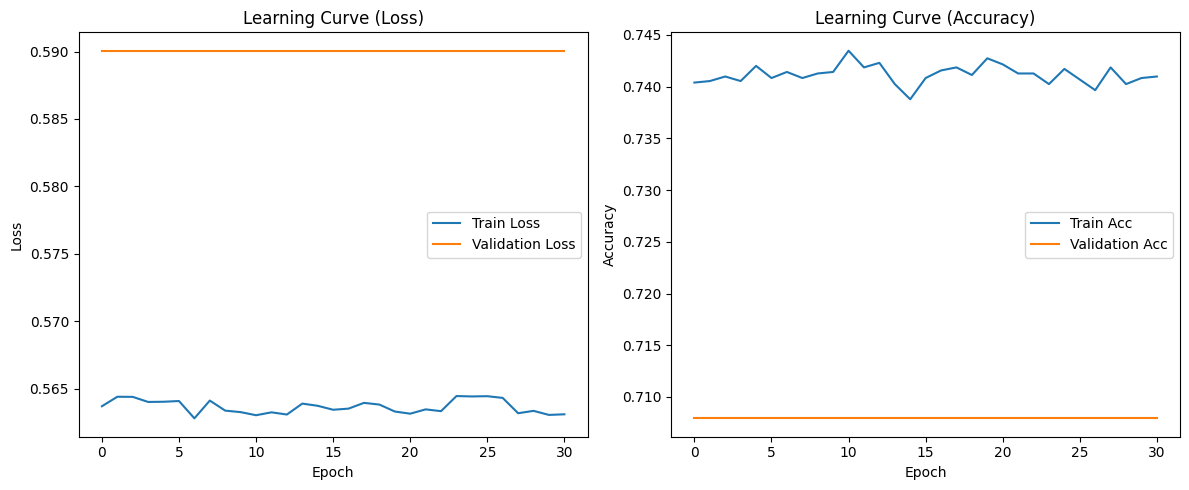

In [41]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import numpy as np

# ======================================
# 🧠 EarlyStopping クラス定義
# ======================================
class EarlyStopping:
    def __init__(self, patience=30, min_delta=0.01):
        """
        patience : 改善が止まってから何エポック待つか
        min_delta : 改善とみなす最小の変化量
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = np.inf
        self.should_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True


# ======================================
# 🏋️‍♂️ 7. 学習ループ（Validation + EarlyStopping）
# ======================================
num_epochs = 500
patience = 30  # 30エポック改善しなければ終了
early_stopping = EarlyStopping(patience=patience, min_delta=1e-4)

train_losses, val_losses = [], []
train_accs, val_accs = [], []

best_model_state = None

for epoch in range(num_epochs):
    # --------------------------
    # 🔹 Training
    # --------------------------
    transformer.train()
    train_loss, all_preds, all_trues = 0, [], []

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        # Forward
        x = embedding(xb)
        x = transformer(x)
        x = x.transpose(1, 2)
        x = pool(x).squeeze(-1)
        x = fc(x)
        out = softmax(x)

        # Loss & Backprop
        loss = criterion(out, yb)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            list(embedding.parameters()) +
            list(transformer.parameters()) +
            list(fc.parameters()),
            max_norm=1.0
        )
        optimizer.step()
        train_loss += loss.item()

        preds = torch.argmax(out, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_trues.extend(yb.cpu().numpy())

    train_loss /= len(train_loader)
    train_acc = accuracy_score(all_trues, all_preds)

    # --------------------------
    # 🔹 Validation
    # --------------------------
    transformer.eval()
    val_loss, val_preds, val_trues = 0, [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            x = embedding(xb)
            x = transformer(x)
            x = x.transpose(1, 2)
            x = pool(x).squeeze(-1)
            x = fc(x)
            out = softmax(x)
            loss = criterion(out, yb)
            val_loss += loss.item()

            preds = torch.argmax(out, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_trues.extend(yb.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc = accuracy_score(val_trues, val_preds)

    # --------------------------
    # 📈 ログ記録とEarlyStopping判定
    # --------------------------
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"TrainLoss: {train_loss:.4f}  ValLoss: {val_loss:.4f}  "
          f"TrainAcc: {train_acc:.4f}  ValAcc: {val_acc:.4f}")

    # ベストモデルを保存
    if val_loss == min(val_losses):
        best_model_state = {
            'embedding': embedding.state_dict(),
            'transformer': transformer.state_dict(),
            'fc': fc.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch
        }

    # Early Stopping
    early_stopping(val_loss)
    if early_stopping.should_stop:
        print(f"⏹ Early Stopping at epoch {epoch+1} (no improvement for {patience} epochs)")
        break


# ======================================
# 💾 ベストモデル保存（任意）
# ======================================
if best_model_state:
    torch.save(best_model_state, "best_model.pth")
    print("✅ ベストモデルを 'best_model.pth' に保存しました。")

# ======================================
# 📊 学習曲線の可視化
# ======================================
plt.figure(figsize=(12, 5))

# --- Loss 曲線 ---
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve (Loss)')
plt.legend()

# --- Accuracy 曲線 ---
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Validation Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Learning Curve (Accuracy)')
plt.legend()

plt.tight_layout()
plt.show()


In [49]:
# ======================================
# 🧾 8. テストデータで評価
# ======================================
model_loss = 0
all_preds = []
all_trues = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        
        x = embedding(xb)
        x = transformer(x)
        x = x.transpose(1, 2)
        x = pool(x).squeeze(-1)
        x = fc(x)
        out = softmax(x)
        
        loss = criterion(out, yb)
        model_loss += loss.item()
        
        preds = torch.argmax(out, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_trues.extend(yb.cpu().numpy())

test_acc = accuracy_score(all_trues, all_preds)
print(f"Test Loss: {model_loss/len(test_loader):.4f}  Test Acc: {test_acc:.4f}")

Test Loss: 0.5911  Test Acc: 0.7093


In [54]:
# ======================================
# 🔮 9. 推論サンプル
# ======================================
# 1系列分のダミーデータで確認
sample = torch.randn(1, seq_len, feature_dim).to(device)

x = embedding(sample)
x = transformer(x)
x = x.transpose(1, 2)
x = pool(x).squeeze(-1)
x = fc(x)
out = softmax(x)

pred_class = torch.argmax(out, dim=1).item()
print("出力確率:", out.detach().cpu().numpy())
print("予測クラス:", pred_class)

出力確率: [[0.8879289  0.11207112]]
予測クラス: 0


# 潜在ベクトル可視化

In [36]:
# ======================================
# 🧩 潜在ベクトル抽出
# ======================================

latent_vectors = []
true_labels = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)

        # Transformer内部出力を取得
        x = embedding(xb)
        x = transformer(x)  # (batch, seq_len, hidden_dim)

        # 系列平均を潜在ベクトルとする（Global Average Pooling）
        latent = x.mean(dim=1)  # (batch, hidden_dim)
        latent_vectors.append(latent.cpu())
        true_labels.append(yb)

latent_vectors = torch.cat(latent_vectors, dim=0)
true_labels = torch.cat(true_labels, dim=0)

print("潜在ベクトル形状:", latent_vectors.shape)

潜在ベクトル形状: torch.Size([1462, 64])


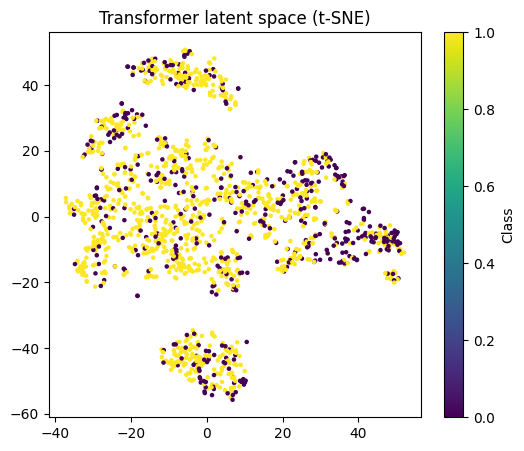

In [37]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
latent_2d = tsne.fit_transform(latent_vectors)

plt.figure(figsize=(6,5))
plt.scatter(latent_2d[:,0], latent_2d[:,1], c=true_labels, cmap="viridis", s=5)
plt.colorbar(label="Class")
plt.title("Transformer latent space (t-SNE)")
plt.show()

# 潜在ベクトルをLightGBMに入力

In [38]:
import lightgbm as lgb
model = lgb.LGBMClassifier()
model.fit(latent_vectors.numpy(), true_labels.numpy())
print("LightGBM acc:", model.score(latent_vectors.numpy(), true_labels.numpy()))

[LightGBM] [Info] Number of positive: 1007, number of negative: 455
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16320
[LightGBM] [Info] Number of data points in the train set: 1462, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.688782 -> initscore=0.794433
[LightGBM] [Info] Start training from score 0.794433
LightGBM acc: 1.0


# アテンション可視化

TypeError: Invalid shape (2, 100, 100) for image data

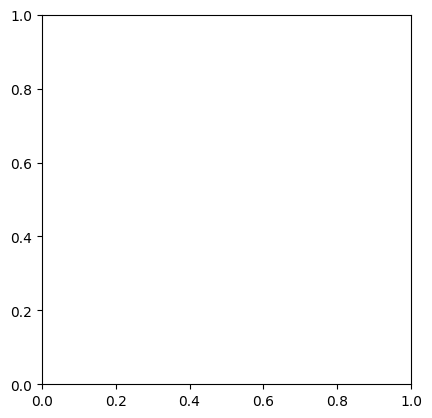

In [ ]:
# ======================================
# 👁️ アテンション可視化
# ======================================
import matplotlib.pyplot as plt

# EncoderLayerのself_attnを直接呼び出すため、1層分通す
sample = next(iter(test_loader))[0][:1].to(device)  # 1系列
x = embedding(sample)

# 最初のEncoder層のAttention重みを取得
encoder_layer = transformer.layers[0]
attn_out, attn_weights = encoder_layer.self_attn(
    x, x, x, need_weights=True, average_attn_weights=False
)  # attn_weights: (num_heads, seq_len, seq_len)

attn = attn_weights[0].detach().cpu().numpy()  # 1ヘッド分
plt.imshow(attn, cmap='hot', interpolation='nearest')
plt.title("Attention Map (head 1)")
plt.xlabel("Key positions")
plt.ylabel("Query positions")
plt.colorbar()
plt.show()


In [39]:
# ======================================
# 🧱 特徴抽出器として利用
# ======================================

# Transformerをfreeze（重み固定）
for p in list(embedding.parameters()) + list(transformer.parameters()):
    p.requires_grad = False

# 新しい分類器を定義
new_fc = nn.Linear(hidden_dim, 3).to(device)
optimizer = optim.Adam(new_fc.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Transformerは固定し、new_fcのみ学習
for epoch in range(5):
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        with torch.no_grad():
            x = embedding(xb)
            x = transformer(x)
            x = x.mean(dim=1)
        out = new_fc(x)
        loss = criterion(out, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss/len(train_loader):.4f}")


Epoch 1 Loss: 0.7834
Epoch 2 Loss: 0.6188
Epoch 3 Loss: 0.6008
Epoch 4 Loss: 0.5911
Epoch 5 Loss: 0.5850


In [40]:
# ======================================
# 👁️ クラスごとのAttention分布比較
# ======================================
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Transformer層のAttentionを格納
attn_class0 = []
attn_class1 = []

encoder_layer = transformer.layers[0]  # 1層目のAttentionを可視化

with torch.no_grad():
    for xb, yb in tqdm(test_loader):
        xb, yb = xb.to(device), yb.to(device)

        # 埋め込み
        x = embedding(xb)

        # Attentionを取得（PyTorch 2.xで利用可）
        _, attn_weights = encoder_layer.self_attn(
            x, x, x,
            need_weights=True,
            average_attn_weights=False
        )  # shape: (num_heads, batch, seq_len, seq_len)

        # バッチ次元を考慮して平均
        attn_mean = attn_weights.mean(dim=(0,1)).detach().cpu().numpy()  # (seq_len, seq_len)

        # クラス別に追加
        if yb.mean().item() < 0.5:  # クラス0
            attn_class0.append(attn_mean)
        else:  # クラス1
            attn_class1.append(attn_mean)

# クラスごとの平均Attention
attn_class0_mean = np.mean(np.stack(attn_class0), axis=0)
attn_class1_mean = np.mean(np.stack(attn_class1), axis=0)

# 差分（Class1 - Class0）
attn_diff = attn_class1_mean - attn_class0_mean

  0%|          | 0/23 [00:00<?, ?it/s]


RuntimeError: mean(): could not infer output dtype. Input dtype must be either a floating point or complex dtype. Got: Long